# About run_sequence_clustering_analysis

This notebook clusters action sequences and analyzes the resulting clusters

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [62]:
df_all = get_df_all_factors(all_vars=False)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Width, Concentration, Separation, Area


We grab the sequences

In [63]:
import pickle
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

## We grab our students and their productivity group

In [64]:
def make_group(row):
    if row['pre']==2:
        return 'Hpre'
    elif row['pre']==0 and row['main']==0:
        return 'LU'
    elif row['pre']==0 and row['main']==1:
        return 'LP'
    elif row['pre']==0 and row['main']==2:
        return 'LP'
    elif row['pre']==1 and row['main']==0:
        return 'MU'
    elif row['pre']==1 and row['main']==1:
        return 'MU'
    elif row['pre']==1 and row['main']==2:
        return 'MP'
    else:
        print row #can't classify student, something is wrong
    
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index'], aggfunc=count_exact)
scores['group'] = scores.apply(make_group,axis=1)

scores = scores[scores['group'].isin(['LU','LP'])]
scores.groupby(['sim_index','group']).describe()

main                                        pre            \
                count  mean   std  min  25%  50%  75%  max count mean  std   
sim_index group                                                              
1         LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0  0.0   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0  0.0   
2         LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0  0.0   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0  0.0   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

In [65]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
df_all.dropna(inplace=True)

We translate to which sequences were productive

In [66]:
df_all.head()

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor,group
0,10127163,L,Concentration,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LP
1,10127163,L,Width,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LP
4,10232160,L,Concentration,0.0,0.0,1.0,1.0,0.0,1,2.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LU
5,10232160,L,Width,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,0.0,1,1,1,1,1,1,4,1,1,1,1,LU
6,10232160,C,Area,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LP


## We grab and tranform sequences

We transform the sequences by blocking certain actions, removing others, merging some and generalizing.

We store all seqs as a list of Sequence() items

In [67]:
transformed_seqs = []
for sim,seqs_by_student in all_seqs.iteritems():
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.remove_actions('V_ruler')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser'])
        seq.block_actions(['G_add','G_add_fail','G_remove','T_remove'])
        seq.translate_variable_actions()
        seq.check_lengths_seq_timecoords()
        transformed_seqs.append(seq)

In [68]:
print len(transformed_seqs)

294


In [69]:
transformed_seqs[0].parameters()

Length:127 actions, sid:23836160, sim:beers, blocked actions:set(['V_separation', 'V_wavelength', 'V_detector', 'V_other', 'V_lightbulb', 'G_add_fail', 'G_add', 'T_remove', 'G_remove', 'P', 'V_width', 'V_area', 'V_concentration', 'V_laser', 'V_battery']),actions removed: set(['ignore', 'V_ruler']), merged_actions: set([('P', 'P_notes')]), has timecoords: True


## We make our prediction array
of which sequence is productive, and remove sequences from students who are not in our productivity groups

In [70]:
Y = []
seqs_to_analyze = []
for i,seq in enumerate(transformed_seqs):
    sid = seq.sid
    sim = {'beers':'L','capacitor':'C'}[seq.sim]
    groups = list(df_all[(df_all['sid']==sid)&(df_all['sim']==sim)]['group']) #two for each variable in sim
    if groups:
        group = groups[0]
        Y.append({'LU':1,'LP':0}[group])
        seqs_to_analyze.append(seq)

In [71]:
len(seqs_to_analyze),len(Y)

(267, 267)

# Prepare feature data matrix
We get all possible subsequences of length 2 to 10.

Features are all possible subsequences. We get rid of those used by only 1 sequence.

For each 147\*2 sequences, we count how many times they used a subsequence.

**Parameters**

In [77]:
shortest = 1
longest = 10
cut_off = 2 #keep sequences used in at least 2 of the N student sequences
print cut_off

2


For all possible subsequences, count how many of the 147*2 sequences they are in.

Ignore the ones in only less than \*cut-off\* number of sequences

In [78]:
count_all_subsequences = Counter()
for seq in seqs_to_analyze:
    sequence = seq.seq
    subseqs_in_seq = []
    for seq_length in range(shortest, longest+1):  # loops through different possible sequence lengths
        subseqs_in_seq.extend([sequence[i:i+seq_length] for i in range(len(sequence)-seq_length+1)])
    count_all_subsequences.update(Counter({','.join(s):1 for s in subseqs_in_seq})) #count of 1 per subseqs

subsequences_counts = Counter()
for e,c in count_all_subsequences.iteritems():
    if c > cut_off: #remove ones used by too few students
        subsequences_counts.update(Counter({e:c}))

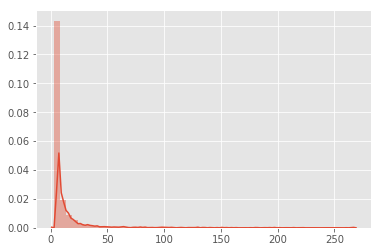

In [79]:
sns.distplot(subsequences_counts.values())

In [80]:
subsequences = list(set(list(subsequences_counts.elements())))
subsequences[0]
len(subsequences)

6787

Make feature matrix

In [81]:
X = np.zeros((len(seqs_to_analyze), len(subsequences)))
for i,seq in enumerate(seqs_to_analyze):
    sequence = ','.join(seq.seq)
    for j,subseq in enumerate(subsequences):
        #count how many times subsequence appears in seq
        X[i][j] = sequence.count(subseq)

# run random forests!

## Find the optimal number and depth of trees

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
from sklearn.model_selection import cross_val_score

In [86]:
nb_trees = [5,10,20,100,500]
depths = [3,5,10,20,None]

mean_scores = []
m = np.zeros((len(nb_trees),len(depths)))
for i,nb in enumerate(nb_trees):
    for j,depth in enumerate(depths):
        classifier = RandomForestClassifier(n_estimators=nb,
                        criterion='entropy',
                        max_depth=depth,
                        min_samples_split=2,
                        min_samples_leaf=1,     
                        bootstrap = True,
                        class_weight = 'balanced', #sets weights of classes given frequency from data in bootstraped samples
                        max_features='sqrt') #use sqrt features to find split
        scores = cross_val_score(classifier, X,Y, cv=5)
        mean_scores.append((nb,depth,np.mean(scores),np.std(scores)))
        print nb, depth, np.mean(scores)
        m[i][j] = np.mean(scores)
        

# Let's use 5 fold cross validation for 5 different number of trees, 3 different optimal depths. So that's train 5*5*3 = 75 models. Yikes!

5 3 0.6738106756974681
5 5 0.6743777885287319
5 10 0.6436838144385314
5 20 0.6549373756920926
5 None 0.6403348922216847
10 3 0.7001639520507446
10 5 0.7038649680159115
10 10 0.6887652529161963
10 20 0.6661882492071172
10 None 0.6663306993495672
20 3 0.733849379132398
20 5 0.6812180831048755
20 10 0.6736709132935548
20 20 0.7035128742675912
20 None 0.6852093748320163
100 3 0.6999489329678009
100 5 0.707568671719615
100 10 0.707426221577165
100 20 0.6886980594527764
100 None 0.6923291942159866
500 3 0.7072837714347149
500 5 0.7148336289845724
500 10 0.707426221577165
500 20 0.69240176315648
500 None 0.7036526366715046


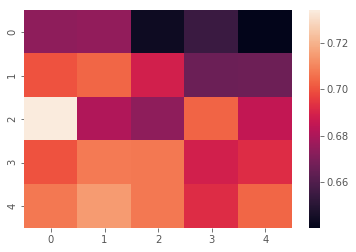

In [87]:
sns.heatmap(m)

It doesn't seem to matter how many trees or the depth. (Not shown here, but using 'log2' for number of boostraping features leads to poorer results and balancing class weights doesn't not anything).

The more trees, the closer we get to the min error rate possible. So there's no point doing more than 10 trees it seems.

Having deep trees leads to overfitting but it seems like after 5 splits, we don't gain any information. This might be telling us that there really are only 5 useful sequences in split our data.

## Tune parameters with Out of Bag error instead of accuracy

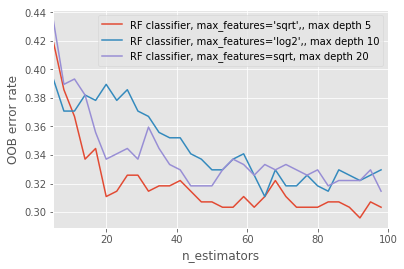

In [88]:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause
from collections import OrderedDict

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RF classifier, max_features='sqrt',, max depth 5",
        RandomForestClassifier(n_estimators=10,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               max_depth = 10,
                               random_state=RANDOM_STATE)),
    ("RF classifier, max_features='log2',, max depth 10",
        RandomForestClassifier(n_estimators=10,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               max_depth = 20,
                               random_state=RANDOM_STATE)),
    ("RF classifier, max_features=sqrt, max depth 20",
        RandomForestClassifier(n_estimators=10,
                               warm_start=True, max_features="sqrt",
                               oob_score=True,
                               max_depth = 30,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,3):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

The Out of bag error stabilises after ~50 trees and is more stable with a lower error rate at a depth of 5. So let's stick with that.

## Analyze resulting tree

In [91]:
nb_trees = 50
depth = 5
classifier = RandomForestClassifier(n_estimators=nb_trees,
                                    criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    min_samples_leaf=1,     
                                    bootstrap = True,
                                    class_weight = 'balanced', #sets weights of classes given frequency from data in bootstraped samples
                                    max_features='sqrt') #use sqrt features to find split
classifier.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [93]:
important_seqs = classifier.feature_importances_.argsort()[-20:][::-1]
seqs_to_viz = []
for i in important_seqs:
    seqs_to_viz.append(subsequences[i])
seqs_to_viz.sort()
seqs_to_viz

['G_axis_outcome,G_axis_trialnumber,P',
 'G_axis_quant',
 'G_scale_linear,P,T_remove',
 'P',
 'Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add',
 'T_add,V_quant,T_add',
 'T_add,V_quant,T_add,P,G_axis_quant',
 'T_add,V_quant,T_add,V_quant',
 'T_add,V_quant,T_add,V_quant,T_add,V_quant',
 'T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant',
 'T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add',
 'V_qual,T_add,V_qual,T_add',
 'V_qual,T_add,V_qual,T_add,V_qual,T_add,V_qual,T_add,V_qual',
 'V_quant',
 'V_quant,T_add',
 'V_quant,T_add,V_quant',
 'V_quant,T_add,V_quant,T_add,V_quant',
 'V_quant,T_add,V_quant,T_add,V_quant,T_add',
 'V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add',
 'V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant']

## Let's lot the frequency and use of these sequences
minus the CVS ones

In [94]:
seqs = ['G_axis_outcome,G_axis_trialnumber,P',
 'G_axis_quant',
 'G_scale_linear,P,T_remove',
 'P',
 'Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add',
 'T_add,V_quant,T_add,P,G_axis_quant',
 'V_qual,T_add,V_qual,T_add',
 'V_qual,T_add,V_qual,T_add,V_qual,T_add,V_qual,T_add,V_qual',
 'V_quant']

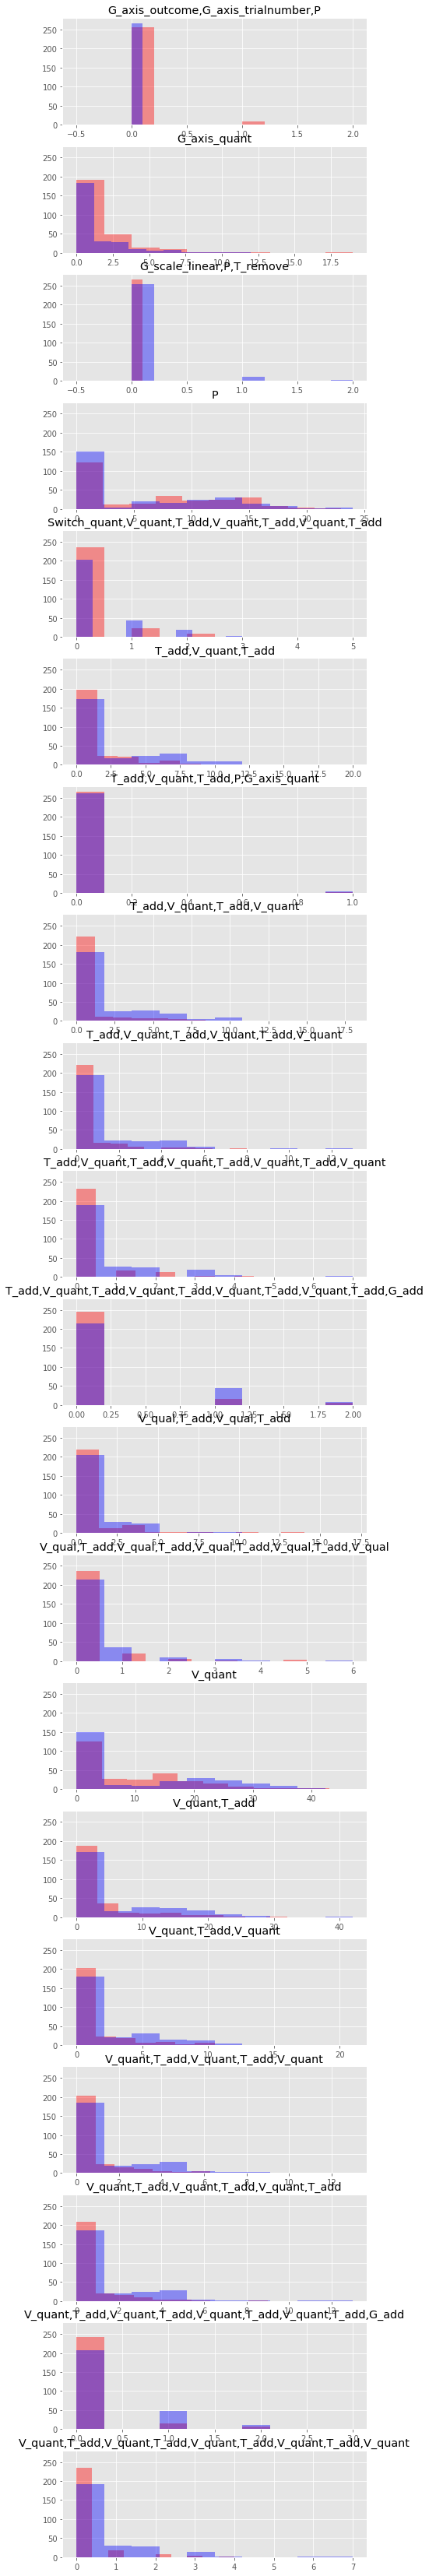

In [124]:
f, axes = plt.subplots(len(seqs_to_viz),1, figsize=(7,3*len(seqs_to_viz)), sharey = True)
for i,s in enumerate(seqs_to_viz):
    ax = axes[i]
    i = subsequences.index(s)
    lu = X[:,i]*Y
    lp = X[:,i]*[1-y for y in Y]
    sns.distplot(lu, kde=False, ax=ax, color='red', bins=10)
    sns.distplot(lp, kde=False, ax=ax, color='blue', bins=10)
    ax.set_title(s)

# Todo

1. Prep data
    * make data point times feature matrix
* Random forests
    * do CVS with different sized trees
        
    
* Analyze!

# Old data
number fo trees, max depth of tree, mean accuracy
100 3 0.7185373326882761
100 5 0.7072138902327582
100 10 0.7072837714347149
100 20 0.7112723754233188
750 3 0.7072837714347149
750 5 0.6998064828253507
750 10 0.714761060044079
750 20 0.7147610600440788
1000 3 0.714903510186529
1000 5 0.7072837714347149
1000 10 0.7071440090308015
1000 20 0.7109175939364618
2000 3 0.714761060044079
2000 5 0.7072837714347149
2000 10 0.7035101865290544
2000 20 0.7072837714347149
5000 3 0.714761060044079
5000 5 0.7109874751384185
5000 10 0.7072138902327582
5000 20 0.7072138902327582